### これは単純なニューラルネットワークでネット上の画像が犬顔か猫顔かを判定するシステムです
### 以下に注意点を示します
・事前に，PyTorch，matplotlib，PIL，requestの各ライブラリをインストールしておく

・データセットがこのプログラムと同じディレクトリ内のフォルダに入っていることを確認する

・network2.pyがこのプログラムと同じディレクトリにあることを確認する

・次の次のコードで書いてあるepochsを減らす（例えば5とか7とか）と処理の時間が減る，ただしAIの精度は落ちるかも

・逆にepochsを20とかに増やすと処理時間は増えるが，AIの精度は上がる

・すべての実行には30分くらいを見ておいたほうが良い

・後半に書いてある注意も読む

In [1]:
# dog_cat_classifier_epoch10ver
# 必要なライブラリのインポート
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

In [2]:
# Data preparation
# ここでAIを作る処理
# Data preparation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
                      ])

train_dataset = torchvision.datasets.ImageFolder(root='./test_set', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = torchvision.datasets.ImageFolder(root='./training_set', transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

# Model initialization
from network2 import SimpleCNN  # Assuming network.py is in the same directory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/20, Train Loss: 2.8570, Val Loss: 1.8508
Epoch 2/20, Train Loss: 0.8953, Val Loss: 0.6975
Epoch 3/20, Train Loss: 0.5823, Val Loss: 0.8930
Epoch 4/20, Train Loss: 0.5187, Val Loss: 0.7002
Epoch 5/20, Train Loss: 0.4310, Val Loss: 0.6361
Epoch 6/20, Train Loss: 0.3860, Val Loss: 0.6452
Epoch 7/20, Train Loss: 0.3386, Val Loss: 0.9591
Epoch 8/20, Train Loss: 0.2780, Val Loss: 0.9635
Epoch 9/20, Train Loss: 0.2182, Val Loss: 0.8406
Epoch 10/20, Train Loss: 0.1642, Val Loss: 0.9486
Epoch 11/20, Train Loss: 0.1613, Val Loss: 1.1523
Epoch 12/20, Train Loss: 0.2039, Val Loss: 1.3991
Epoch 13/20, Train Loss: 0.2045, Val Loss: 0.9094
Epoch 14/20, Train Loss: 0.0903, Val Loss: 0.9957
Epoch 15/20, Train Loss: 0.0651, Val Loss: 1.3837
Epoch 16/20, Train Loss: 0.0570, Val Loss: 1.2827
Epoch 17/20, Train Loss: 0.0269, Val Loss: 1.2940
Epoch 18/20, Train Loss: 0.0555, Val Loss: 1.3162
Epoch 19/20, Train Loss: 0.0563, Val Loss: 1.4120
Epoch 20/20, Train Loss: 0.0578, Val Loss: 1.4288


In [3]:
# モデルの保存
torch.save(model, 'model_CNN.pth')

### 注意： これより前の処理は一回だけで良い，もう一回実行すると大変なことになる（振り出しに戻ってしまい時間がかかる）
### モデルができたら，以下の処理を順番に実行する
・まずは，学習曲線を描画

・次に，URLから画像を取り込むための関数を作る

・関数を呼び出して，ネット上の画像を取り込んで予測

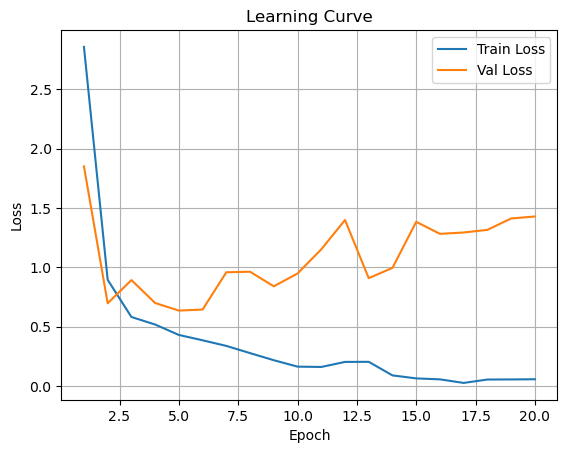

In [4]:
# Plotting learning curves
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.grid()
plt.legend()
plt.show()

In [6]:
model = torch.load("model_CNN.pth")

# URL-based prediction function
def predict_from_url(url):
    transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
    ])
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img_transformed = transform(img).unsqueeze(0)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(img_transformed)
        probability = F.softmax(output, dim=1)
        _, predicted = torch.max(output, 1)
        class_names = ['Cat', 'Dog']
        return class_names[predicted.item()], probability.tolist()[0]

In [32]:
# 判定したい画像のURLをコピペ
# url = " " のようにして" "の中にコピペする 
url = "https://cdn.royalcanin-weshare-online.io/HiJiPmYBaxEApS7LmAfe/v1/ed7a-how-to-buy-a-puppy-article-dog"

In [33]:
predicted_class, probabilities = predict_from_url(url)
print(f"Predicted class: {predicted_class}")
print(f"Probability(Cat): {probabilities[0]}")
print(f"Probability(Dog): {probabilities[1]}")

Predicted class: Dog
Probability(Cat): 3.91708999814e-05
Probability(Dog): 0.9999607801437378
